# Modelo

### Librerías y carga del dataset

In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

import matplotlib.pyplot as plt
import pickle
import os

# Directorio que contiene los archivos pkl
directorio = '../data/'  # Actualiza con la ruta correcta

# Lista para almacenar los DataFrames de los archivos pkl
dataframes = []

# Recorre los archivos en el directorio
for archivo in os.listdir(directorio):
    if archivo.endswith('.pkl'):
        ruta_archivo = os.path.join(directorio, archivo)
        with open(ruta_archivo, 'rb') as f:
            data = pickle.load(f)
        dataframes.append(data)

# Combina los DataFrames en uno solo
data = pd.concat(dataframes, ignore_index=True)

### Datos sin procesar

In [44]:
print(data.head())
print("filas-data-sucia: ", len(data))

   TRANSACTION_ID TIEMPO_DESDE_ULTIMA_TX_S DIA_TX CLIENTE_ID TERMINAL_ID  \
0          109006                  1728250     20       2537         316   
1          109007                  1728315     20       4606          86   
2          109008                  1728420     20       7507         271   
3          109009                  1728502     20       5030         281   
4          109010                  1728805     20       4739         280   

   MONTO_TX         TX_DATETIME    year  month   day  hour  minute  \
0  63406.57 2023-01-21 00:04:10  2023.0    1.0  21.0   0.0     4.0   
1  47177.10 2023-01-21 00:05:15  2023.0    1.0  21.0   0.0     5.0   
2  41771.86 2023-01-21 00:07:00  2023.0    1.0  21.0   0.0     7.0   
3  40278.29 2023-01-21 00:08:22  2023.0    1.0  21.0   0.0     8.0   
4  39548.41 2023-01-21 00:13:25  2023.0    1.0  21.0   0.0    13.0   

   x_pos_terminal  y_pos_terminal  TX_FRAUD  TX_FRAUD_SCENARIO  
0       22.600080       40.416937         0              

### Datos filtrados

In [45]:
data = data.drop('TRANSACTION_ID', axis=1)
data = data.drop('CLIENTE_ID', axis=1)
data = data[data['TX_FRAUD'] == 1]
data = data.sort_values(by=['TX_DATETIME'])
print(data.head())
print("total-filas: ",len(data) )

       TIEMPO_DESDE_ULTIMA_TX_S DIA_TX TERMINAL_ID   MONTO_TX  \
125412                     1524      0         429  139447.11   
125417                     1805      0          93   92739.05   
125419                     1911      0         380  115776.96   
125432                     2544      0         233  139610.64   
125433                     2552      0         210  132291.02   

               TX_DATETIME    year  month  day  hour  minute  x_pos_terminal  \
125412 2023-01-01 00:25:24  2023.0    1.0  1.0   0.0    25.0        3.203366   
125417 2023-01-01 00:30:05  2023.0    1.0  1.0   0.0    30.0       49.140856   
125419 2023-01-01 00:31:51  2023.0    1.0  1.0   0.0    31.0       45.234308   
125432 2023-01-01 00:42:24  2023.0    1.0  1.0   0.0    42.0       25.412377   
125433 2023-01-01 00:42:32  2023.0    1.0  1.0   0.0    42.0       28.550428   

        y_pos_terminal  TX_FRAUD  TX_FRAUD_SCENARIO  
125412       17.765518         1                  1  
125417        9.0806

### Random Forest

Mean Squared Error (MSE): 1.2183823515876586
Mean Absolute Error (MAE): 0.7431304137209489
R-squared: 0.9831757216489442


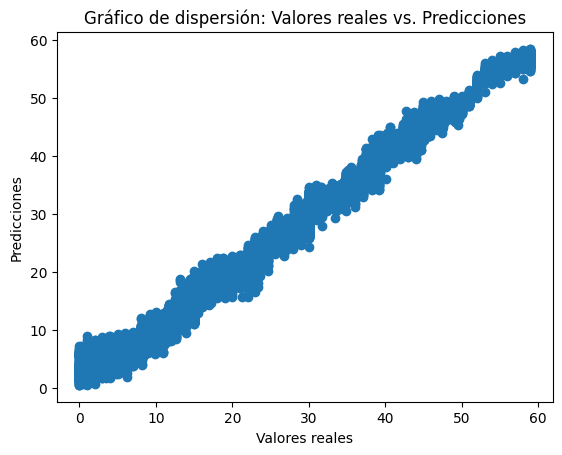

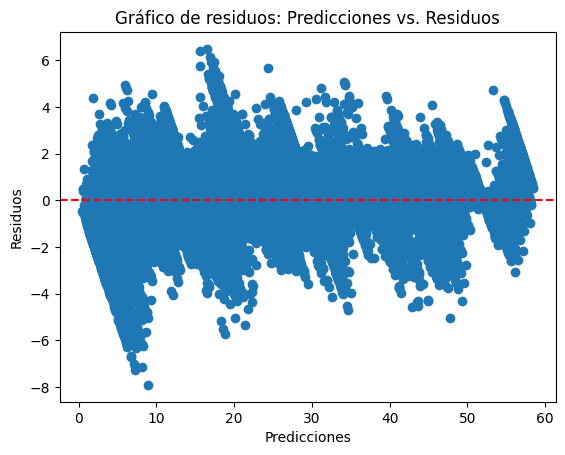

In [46]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
# Variables de entrada
X = data[['x_pos_terminal', 'y_pos_terminal','month', 'day', 'hour', 'minute']]
# Variables objetivo
y = data[['x_pos_terminal', 'y_pos_terminal','month','day', 'hour', 'minute']]

# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(oob_score=True)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Calcular las métricas
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Imprimir las métricas
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared:", r2)

plt.scatter(y_test, y_pred)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Gráfico de dispersión: Valores reales vs. Predicciones')
plt.show()

# Calcular los residuos
residuals = y_test - y_pred

# Gráfico de residuos
plt.scatter(y_pred, residuals)
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.title('Gráfico de residuos: Predicciones vs. Residuos')
plt.axhline(y=0, color='r', linestyle='--')  # Línea de referencia en 0
plt.show()

### Curvas de aprendizaje

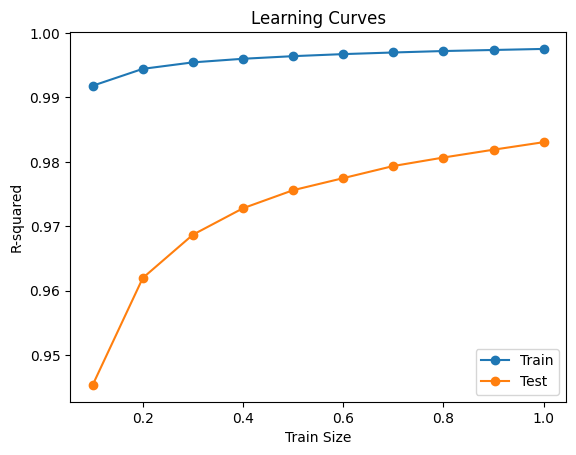

In [47]:
train_sizes = np.linspace(0.1, 1.0, 10)

train_scores = []
test_scores = []

for train_size in train_sizes:
    # Tamaño del conjunto de entrenamiento actual
    current_train_size = int(train_size * len(X_train))
    
    # Subconjunto de entrenamiento actual
    X_train_subset = X_train[:current_train_size]
    y_train_subset = y_train[:current_train_size]
    
    # Entrenar el modelo
    model = RandomForestRegressor(oob_score=True)
    model.fit(X_train_subset, y_train_subset)
    
    # Predecir en el conjunto de entrenamiento y prueba
    y_train_pred = model.predict(X_train_subset)
    y_test_pred = model.predict(X_test)
    
    # Calcular el rendimiento (por ejemplo, R-squared)
    train_score = r2_score(y_train_subset, y_train_pred)
    test_score = r2_score(y_test, y_test_pred)
    
    # Agregar a las listas de puntajes
    train_scores.append(train_score)
    test_scores.append(test_score)

# Graficar las curvas de aprendizaje
plt.plot(train_sizes, train_scores, 'o-', label='Train')
plt.plot(train_sizes, test_scores, 'o-', label='Test')
plt.xlabel('Train Size')
plt.ylabel('R-squared')
plt.title('Learning Curves')
plt.legend()
plt.show()

### Validación Cruzada

In [48]:
### Validación cruzada

In [49]:
y_pred_rounded = y_pred.copy()  # Copia los valores predichos

# Redondea los valores a enteros en las últimas 4 columnas
y_pred_rounded[:, -4:] = y_pred_rounded[:, -4:].round().astype(int)

print(y_pred_rounded)
rounded_df = pd.DataFrame(y_pred_rounded, columns=y_test.columns)
rounded_df.to_csv('../output/predicciones.csv', index=False)

[[40.45017095 17.22635588  1.          6.          7.         18.        ]
 [40.73530301 33.40774361  1.         12.         15.         11.        ]
 [46.60117532 45.5782203   1.         21.         10.         28.        ]
 ...
 [ 4.01209759 34.82703095  1.         13.         15.         40.        ]
 [48.56762217 12.05247347  1.          5.         15.         19.        ]
 [ 5.66890834  8.70977264  1.         13.         12.          4.        ]]


### Validación

In [50]:
validacion_directorio = '../validation/'

dataframe_validation = []

for archivo in os.listdir(validacion_directorio):
    if archivo.endswith('.pkl'):
        ruta_archivo = os.path.join(validacion_directorio, archivo)
        with open(ruta_archivo, 'rb') as f:
            data_val = pickle.load(f)
        dataframe_validation.append(data_val)

# Combina los DataFrames en uno solo
data_val = pd.concat(dataframe_validation, ignore_index=True)

In [51]:
data_val = data_val.drop('TRANSACTION_ID', axis=1)
data_val = data_val.drop('CLIENTE_ID', axis=1)
data_val = data_val[data_val['TX_FRAUD'] == 1]
data_val = data_val.sort_values(by=['TX_DATETIME'])
print(data_val.head())
print("total-filas: ",len(data_val) )

    TIEMPO_DESDE_ULTIMA_TX_S DIA_TX TERMINAL_ID   MONTO_TX  \
756                     1524      0          98  139447.11   
757                     1805      0          46   92739.05   
759                     5559      0          29   90911.63   
760                     6890      0          97   88554.72   
766                     9344      0          86   19788.93   

            TX_DATETIME    year  month  day  hour  minute  x_pos_terminal  \
756 2023-01-01 00:25:24  2023.0    1.0  1.0   0.0    25.0        3.203366   
757 2023-01-01 00:30:05  2023.0    1.0  1.0   0.0    30.0       49.952026   
759 2023-01-01 01:32:39  2023.0    1.0  1.0   1.0    32.0       41.457345   
760 2023-01-01 01:54:50  2023.0    1.0  1.0   1.0    54.0       45.843067   
766 2023-01-01 02:35:44  2023.0    1.0  1.0   2.0    35.0       14.022200   

     y_pos_terminal  TX_FRAUD  TX_FRAUD_SCENARIO  
756       17.765518         1                  1  
757       11.804449         1                  1  
759       4

In [52]:
X_val = data_val[['x_pos_terminal', 'y_pos_terminal','month', 'day', 'hour', 'minute']]
# Variables objetivo
y_val = data_val[['x_pos_terminal', 'y_pos_terminal','month','day', 'hour', 'minute']]

# Realizar predicciones en el conjunto de prueba
y_pred_val = model.predict(X_val)

y_pred_val_original = y_pred_val.copy()  # Copia los valores predichos

y_pred_rounded_val = y_pred_val.copy()  # Copia los valores predichos

# Redondea los valores a enteros en las últimas 4 columnas
y_pred_rounded_val[:, -4:] = y_pred_rounded_val[:, -4:].round().astype(int)

print(y_pred_rounded_val)
rounded_df_val = pd.DataFrame(y_pred_rounded_val, columns=y_val.columns)
rounded_df_val.to_csv('../output/predicciones_val.csv', index=False)

# Calcular las métricas
mse_val = mean_squared_error(y_val, y_pred_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

# Imprimir las métricas
print("VAL - Mean Squared Error (MSE):", mse_val)
print("VAL - Mean Absolute Error (MAE):", mae_val)
print("VAL - R-squared:", r2_val)


[[ 2.88859979 17.63618464  1.          2.          2.         25.        ]
 [47.53014235 11.77694223  1.          5.          6.         33.        ]
 [43.57578749 46.05383048  1.          4.          5.         34.        ]
 ...
 [ 3.90565564 37.15511434  1.         29.         21.         18.        ]
 [39.18425174 18.78054998  1.         25.         22.         25.        ]
 [26.93223742 44.09418347  1.         29.         23.         41.        ]]
VAL - Mean Squared Error (MSE): 1.3923917187678798
VAL - Mean Absolute Error (MAE): 0.7589198939949998
VAL - R-squared: 0.983297084829641


In [53]:
print(y_pred_val_original)

[[ 2.88859979 17.63618464  1.          2.44        1.81       25.04      ]
 [47.53014235 11.77694223  1.          5.03        5.69       32.67      ]
 [43.57578749 46.05383048  1.          4.15        5.12       33.64      ]
 ...
 [ 3.90565564 37.15511434  1.         28.72       20.56       18.46      ]
 [39.18425174 18.78054998  1.         25.19       21.86       25.18      ]
 [26.93223742 44.09418347  1.         29.07       22.64       40.83      ]]
